In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from src.part3.MLP import MultiLayerPerceptron as MLP
from src.common.linear_data import generate_samples

## 모든 것의 시작 `nn.Module` 

`nn.Module`은 앞으로 여러분들이 심층신경망을 `pytorch`로 구현할 때, 거의 모든 경우 base class로 사용하게 될 모듈입니다. 예제를 확인하면서 어떻게 `nn.Module` 를 사용하는지 확인해보도록 하죠.

```python
import torch.nn as nn

class MultiLayerPerceptron(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list,
                 hidden_act: str,
                 out_act: str):
        super(MultiLayerPerceptron, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_act = getattr(nn, hidden_act)()
        self.out_act = getattr(nn, out_act)()

        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_act)
            else:
                self.layers.append(self.hidden_act)

    def forward(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs
```

아주 아주 특별한 경우가 아니라면, 여러분들께서는 자신만의 심층신경망을 만들 때 `nn.Module`을 상속받은 후 최소 두가지를 구현하게 되실거에요.

### 1. `__init__`

__init__ 은 파이썬의 class constructor 이죠? 항상 컨스트럭터의 첫줄에는
```python
super(MultiLayerPerceptron, self).__init__()
```
과 같은 형태로 parent class, 즉 `nn.module`을 초기화 해주세요.
만약 그렇지 않으면, 뒤에 설명드릴 `nn.moudle`의 강력한 기능을 잃게 됩니다.
### 2.`forward()`
forward()는 심층신경망의 연산 과정을 정의하는 함수입니다. 위의 사례에서는 각 레이어들 (`linear`, `activation`)을 번갈아가면서 사용해서 MLP의 연산과정을 구현했던 것을 확인해보면 좋겠네요.

`nn.module`은 `forward()`로 `__call__()` overriding 합니다. 보기에 좋으라고 그냥 오버라이딩을 하는건 아니고, `nn.module`의 내부에서 `pre_forward_hook`, `post_forward_hook`등을 활용해서 automatic differentiation 에 필요한 기능등을 보조해줍니다.

따라서! 아주 특별한 경우가 아니라면 `forward()`를 구현하고 심층신경망 연산을 진행할때도 `forward()`함수를 사용하는 것을 권장합니다.

## `nn.Module` 에 대한 조금은 deep한 이야기

`nn.Module`은 생각보다 훨씬 더 강력한 편의기능들을 가지고 있습니다. 몇몇 가지 중요한 특징 및 기능에 대해서 알아보도록 하겠습니다.

> `nn.Module`에 __등록되는__ `파라미터` 및 다른 `nn.Module`은 `nn.Module`의 `childrun` 으로 관리된다. <br> ~"아니 이게 무슨 소리야"~

주) `pytorch` 에서 `파라미터`는 미분을 계산해야하는 텐서들을 지칭합니다.

In [3]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()        
        self.layer1 = nn.Linear(5,2)
        self.layer2 = nn.Linear(5,2)
        # 학습중 업데이트가 되지만, 미분을 활용한 업데이트를 하지 않는 텐서들을 등록할 때
        # 혹은 차후에 저장해야하는 텐서값 일때 ex) epsilon-탐욕 정책의 epsilon 
        self.register_buffer('w', torch.zeros(5)) 

In [5]:
mm = MyModel()

In [6]:
for c in mm.children():
    print(c)    

Linear(in_features=5, out_features=2, bias=True)
Linear(in_features=5, out_features=2, bias=True)


## mm.parameters()

mm.parameters() 는 모델 `mm` 안에 있는 파라미터들을 모두 반환해주는 generator 입니다. <br>
아마도 `nn.Module`의 기능중 `forward()` 다음으로, 가장 많이 쓰이는 녀석이 될거에요. 이전 실습에서는
이 기능을 활용해서, optimizer에 최적화 대상인 파라미터들을 등록해줬었던거 기억하시죠?

In [9]:
for p in mm.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0641,  0.0723,  0.1422,  0.3769,  0.3619],
        [-0.4159, -0.1893,  0.2862,  0.2848, -0.3148]], requires_grad=True)
Parameter containing:
tensor([0.0628, 0.0968], requires_grad=True)
Parameter containing:
tensor([[-0.3693, -0.2186, -0.3672, -0.3399, -0.3417],
        [ 0.0114, -0.4422,  0.0193,  0.0912,  0.3365]], requires_grad=True)
Parameter containing:
tensor([ 0.0863, -0.4010], requires_grad=True)


In [10]:
for p in mm.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0641,  0.0723,  0.1422,  0.3769,  0.3619],
        [-0.4159, -0.1893,  0.2862,  0.2848, -0.3148]], requires_grad=True)
Parameter containing:
tensor([0.0628, 0.0968], requires_grad=True)
Parameter containing:
tensor([[-0.3693, -0.2186, -0.3672, -0.3399, -0.3417],
        [ 0.0114, -0.4422,  0.0193,  0.0912,  0.3365]], requires_grad=True)
Parameter containing:
tensor([ 0.0863, -0.4010], requires_grad=True)


## model.to('device')
`pytorch`는 GPU을 활용해 텐서 연산 가속화를 지원합니다. 이때 연산하려는 텐서들은 모두 하나의 장치에 있어야합니다. 예를 들어, 모델의 입력으로 사용 할 텐서 $x$ 는 `cpu` 에 (좀 더 자세히는 `ram`에), 모델의 파라미터들은 `gpu`에 등록되어있다면 $x$와 파라미터를 연산하는 것은 불가능합니다. 이때 간단하게 한 줄로 모델에 등록되어있는 파라미터들을 각각의 장치로 옮기는 것이 가능합니다.

> cpu로 모델의 파라미터 옮기기
```python
model.to('cpu')
```

> gpu로 모델의 파라미터 옮기기
```python
model.to('cuda')
```

주) `cuda`는 그래픽카드 제조사인 Nvidia의 GPGPU 기술의 이름

## model.eval(), model.train()
모델의 작동하는 방식이, 모델을 평가할 때와 `evaluation (eval)`때와 학습`train`때에 따라 달라지는 경우들이 있습니다. 예를 들어, Q-Learning 에서 train 때는 $\epsilon$-탐욕적 정책을 활용하지만, 모델의 성능을 평가하고 싶을 때는 탐욕적 정책을 사용하는 경우가 되겠죠? 그런 경우는 어떻게 할 수 있을까요?

```python
class QLearner(nn.Module):
    
    def __init__():
        ...
   
    def forward():
        if self.train: <- 현재 상태가 'train' 인지 아닌지 알려주는 boolean
            # 탐욕적 정책을 구현
        else:
            # e-탐욕적 정책을 구현
```

> 모델을 train 모드로 바꾸기
```python
model.train()
```

> 모델을 eval 모드로 바꾸기
```python
model.eval()
```

## 다층 퍼셉트론 모델 만들기

In [23]:
mlp = MLP(input_dim=1, 
          output_dim=1,
          num_neurons=[64],
          hidden_act='Identity',
          out_act='Identity')

In [24]:
mlp

MultiLayerPerceptron(
  (hidden_act): Identity()
  (out_act): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Identity()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Identity()
  )
)

## model.state_dict()
`model.state_dict()` 는 모델의 파라미터 값 및 buffer의 현재 상태등을 저장해놓은 dictionary 입니다.
차후에 <5. 심층강화학습> 자주 사용하게 될건데요. 많은 경우, 훈련중 혹은 훈련이 끝난 모델의 파라미터를 구한 후 디스크에 저장하는 용도로 사용하게 됩니다. 이 경우에는 똑같은 모델 두개를 만들기 위해서 사용해볼까요?

In [25]:
mlp.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.1415],
                      [ 0.8691],
                      [-0.3812],
                      [ 0.6464],
                      [ 0.4687],
                      [ 0.5709],
                      [ 0.4494],
                      [ 0.0378],
                      [ 0.6515],
                      [ 0.6540],
                      [ 0.8177],
                      [ 0.3466],
                      [ 0.1326],
                      [-0.2442],
                      [-0.1439],
                      [-0.2956],
                      [ 0.8705],
                      [ 0.5450],
                      [-0.0301],
                      [-0.5259],
                      [ 0.2971],
                      [ 0.4574],
                      [ 0.6703],
                      [ 0.6405],
                      [ 0.9510],
                      [ 0.0935],
                      [-0.8647],
                      [-0.0436],
                      [-0.7319],
          

In [26]:
mlp2 = MLP(input_dim=1, 
           output_dim=1,
           num_neurons=[64],
           hidden_act='Identity',
           out_act='Identity')

mlp2.load_state_dict(mlp.state_dict())

<All keys matched successfully>

In [27]:
mlp2.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.1415],
                      [ 0.8691],
                      [-0.3812],
                      [ 0.6464],
                      [ 0.4687],
                      [ 0.5709],
                      [ 0.4494],
                      [ 0.0378],
                      [ 0.6515],
                      [ 0.6540],
                      [ 0.8177],
                      [ 0.3466],
                      [ 0.1326],
                      [-0.2442],
                      [-0.1439],
                      [-0.2956],
                      [ 0.8705],
                      [ 0.5450],
                      [-0.0301],
                      [-0.5259],
                      [ 0.2971],
                      [ 0.4574],
                      [ 0.6703],
                      [ 0.6405],
                      [ 0.9510],
                      [ 0.0935],
                      [-0.8647],
                      [-0.0436],
                      [-0.7319],
          

In [28]:
w = 1.0
b = 0.5
xs, ys = generate_samples(512, w=w, b=b)

## `torch`의 `Dataset` 및 `Dataloader`로 mini batching 구현하기

수업 시간에 배웠던 Mini batching 을 활용하는 Stochastic Gradient Descent (SGD) 기법들을 기억하시나요? 메모리에 Full-batch -우리에게 주어진 데이터 전체- 를 한번에 올리지 못할 때, 전체 데이터를 일부씩 나눠서 경사하강법을 활용해서 학습하는 기법이었죠? 이런 기법을 직접 데이터를 가지고 구현하려면 상당히 번거롭습니다. 물론 강화학습에서는 그 필요성이 다른 경우에 비해 적긴하지만, 그래도 간단하게 알아보고 넘어가도록 하죠.

주) SGD가 학습알고리즘이 좀 더 좋은 local 최적점으로 수렴하는데 도움이 된다는 이론적인 연구들이 나오고 있습니다. 이 결과는 실제로 실험을 해봐도 대체로 그런 양상을 보입니다.

In [29]:
ds = torch.utils.data.TensorDataset(xs, ys)
data_loader = torch.utils.data.DataLoader(ds, batch_size=64)
full_loader = torch.utils.data.DataLoader(ds, batch_size=512)

## MLP 훈련하기

In [30]:
epoch = 64 # 전체의 데이터셋을 몇번 반복할것인가?
opt = torch.optim.Adam(params=mlp.parameters(), lr=1e-3)
criteria = torch.nn.MSELoss()

sgd_losses = []
for e in range(epoch):
    for x, y in data_loader:
        pred = mlp(x) # forward 를 활용해서 모델의 예측치를 계산
        loss = criteria(pred, y) # MSE로 오차계산
        
        opt.zero_grad() 
        loss.backward() # loss의 파라미터에 대한 편미분 계산
        opt.step() # 경사 하강법을 이용해서 파라미터 개선
    
    # 전체 데이터셋에 대한 오차 계산
    pred = mlp(xs) 
    loss = criteria(pred, ys)    
    loss = loss.detach().numpy() # torch.tensor를 numpy.array로 변환
    
    # another option
    """
    with torch.no_grad():
        pred = mlp(xs) 
        loss = criteria(pred, ys).numpy()
    """
    
    sgd_losses.append(loss)

Text(0.5, 1.0, 'training loss curve')

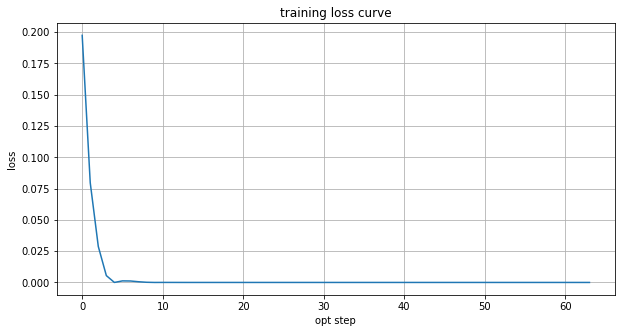

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.grid()
ax.plot(sgd_losses)
ax.set_xlabel('opt step')
ax.set_ylabel('loss')
ax.set_title('training loss curve')

## 과연 SGD가 GD보다 좋은 성능을 보여줄까?

In [32]:
def train_model(model, opt, loader, epoch, criteria, xs, ys):
    losses = []
    for e in range(epoch):
        for x, y in loader:
            pred = model(x) # forward 를 활용해서 모델의 예측치를 계산
            loss = criteria(pred, y) # MSE로 오차계산

            opt.zero_grad() 
            loss.backward() # loss의 파라미터에 대한 편미분 계산
            opt.step() # 경사 하강법을 이용해서 파라미터 개선

        # 전체 데이터셋에 대한 오차 계산
        pred = model(xs)
        loss = criteria(pred, ys)
        losses.append(loss.detach().numpy())
    return losses
    
def run_minibatch_fullbatch(num_reps : int, 
                            n_samples : int, 
                            batch_size : int, 
                            epoch : int):
    criteria = torch.nn.MSELoss()
    
    sgd_losses = []
    gd_losses = []
    
    for _ in range(num_reps):
        mlp = MLP(input_dim=1, 
                  output_dim=1,
                  num_neurons=[64],
                  hidden_act='Identity',
                  out_act='Identity')
        
        opt = torch.optim.Adam(params=mlp.parameters(), lr=1e-3)

        mlp2 = MLP(input_dim=1, 
                   output_dim=1,
                   num_neurons=[64],
                   hidden_act='Identity',
                   out_act='Identity')
        mlp2.load_state_dict(mlp.state_dict())
        opt2 = torch.optim.Adam(params=mlp2.parameters(), lr=1e-3)

        xs, ys = generate_samples(n_samples)
        ds = torch.utils.data.TensorDataset(xs, ys)
        data_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
        full_loader = torch.utils.data.DataLoader(ds, batch_size=n_samples)
        
        # SGD - Mini batch
        sgd_loss = train_model(mlp, opt, data_loader, epoch, criteria, xs, ys)        
        sgd_losses.append(sgd_loss)
        
        # GD - Full batch
        gd_loss = train_model(mlp2, opt2, full_loader, epoch, criteria, xs, ys)        
        gd_losses.append(gd_loss)
    
    sgd_losses = np.stack(sgd_losses)
    gd_losses = np.stack(gd_losses)
    return sgd_losses, gd_losses

In [33]:
sgd_losses, gd_losses = run_minibatch_fullbatch(50, 128, 32, 30)

In [34]:
sgd_loss_mean = np.mean(sgd_losses, axis=0)
sgd_loss_std = np.std(sgd_losses, axis=-0)

In [35]:
gd_loss_mean = np.mean(gd_losses, axis=0)
gd_loss_std = np.std(gd_losses, axis=-0)

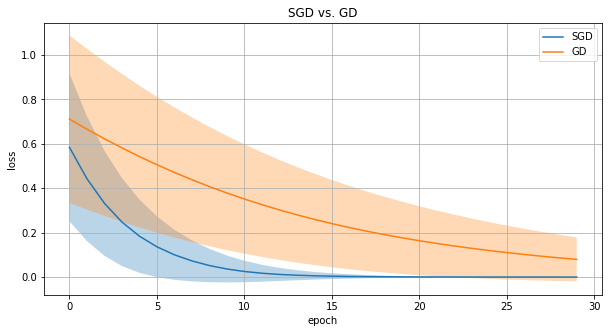

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=range(sgd_loss_mean.shape[0]),
                y1=sgd_loss_mean + sgd_loss_std,
                y2=sgd_loss_mean - sgd_loss_std,
                alpha=0.3)
ax.plot(sgd_loss_mean, label='SGD')
ax.fill_between(x=range(gd_loss_mean.shape[0]),
                y1=gd_loss_mean + gd_loss_std,
                y2=gd_loss_mean - gd_loss_std,
                alpha=0.3)
ax.plot(gd_loss_mean, label='GD')
ax.legend()

_ = ax.set_xlabel('epoch')
_ = ax.set_ylabel('loss')
_ = ax.set_title('SGD vs. GD')